# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
from cs231n.classifiers.softmax import softmax_loss_naive_soln
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('soln loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.358888
soln loss: 2.358888
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*
We expect all the scores to be evenly distributed, so e^S_yi = e^S_j for all j. This leads to the arguemnt to the
log function to be ~1/N where N is number of classes. In this case, N = 10. 

In [4]:

### THIS CELL USES THE softmax_loss_naive_soln, which I stole from here:
# https://github.com/ethan-mgallagher/cs231/blob/master/cs231n/classifiers/softmax.py
# 
# There may be better solutions out there. I didn't try hard
#
# If you look at the output below, however, you'll see that this gradient is not correct
#
# The next cell uses my solution, and the gradient differs from the numerical estimation by ~10^-8, which 
# seems *more correct*. I expected to get ~10^-11 difference as was seen in the SVM classifier. 

# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive_soln(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive_soln(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

print("add regularization")
# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive_soln(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive_soln(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 3.463156 analytic: 3.096394, relative error: 5.591267e-02
numerical: -0.056614 analytic: -0.161419, relative error: 4.806806e-01
numerical: -0.024565 analytic: -0.043594, relative error: 2.791822e-01
numerical: -2.012206 analytic: -1.887563, relative error: 3.196168e-02
numerical: -3.961506 analytic: -3.594083, relative error: 4.862930e-02
numerical: 3.579744 analytic: 3.286342, relative error: 4.273220e-02
numerical: -4.228863 analytic: -3.835356, relative error: 4.879677e-02
numerical: -8.414481 analytic: -7.692400, relative error: 4.483059e-02
numerical: 3.728569 analytic: 3.338648, relative error: 5.517325e-02
numerical: -1.264521 analytic: -1.208195, relative error: 2.277908e-02
add regularization
numerical: 1.184028 analytic: 1.007165, relative error: 8.071537e-02
numerical: 0.678759 analytic: 0.702127, relative error: 1.692255e-02
numerical: -6.001819 analytic: -5.484676, relative error: 4.502182e-02
numerical: 0.389983 analytic: 0.348493, relative error: 5.618331e-02

In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

print("add regularization")
# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -3.354937 analytic: -3.354937, relative error: 4.876624e-09
numerical: -0.423490 analytic: -0.423490, relative error: 9.392492e-08
numerical: -4.855241 analytic: -4.855241, relative error: 1.240579e-08
numerical: 0.209670 analytic: 0.209669, relative error: 4.767618e-07
numerical: 2.238543 analytic: 2.238543, relative error: 1.870795e-08
numerical: 1.470117 analytic: 1.470117, relative error: 3.035536e-08
numerical: 1.036100 analytic: 1.036100, relative error: 9.151071e-08
numerical: 2.385435 analytic: 2.385435, relative error: 7.614619e-09
numerical: -0.282571 analytic: -0.282571, relative error: 1.074735e-07
numerical: -1.572437 analytic: -1.572437, relative error: 1.680861e-08
add regularization
numerical: -2.282506 analytic: -2.282506, relative error: 1.442555e-09
numerical: 3.038803 analytic: 3.038803, relative error: 2.598129e-09
numerical: -0.177995 analytic: -0.177995, relative error: 1.855621e-07
numerical: 1.864537 analytic: 1.864537, relative error: 3.729511e-08
n

In [11]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
from cs231n.classifiers.softmax import softmax_loss_vectorized_soln

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.360976e+00 computed in 0.134476s
vectorized loss: 2.360976e+00 computed in 0.006367s
Loss difference: 0.000000
Gradient difference: 0.000000


In [13]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

learning_rates = np.logspace(-9, -6, 12) 
regularization_strengths = np.logspace(3, 9, 12) 

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
iters = 100
for lr in learning_rates:
    for reg in regularization_strengths:
        
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=iters)
        
        y_train_pred = softmax.predict(X_train)
        acc_train = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        acc_val = np.mean(y_val == y_val_pred)
        
        results[(lr, reg)] = (acc_train, acc_val)
        
        print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, acc_train, acc_val))
        
        if best_val < acc_val:
            best_val = acc_val
            best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
# for lr, reg in sorted(results):
#     train_accuracy, val_accuracy = results[(lr, reg)]
#     print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
#                 lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-09 reg 1.000000e+03 train accuracy: 0.108082 val accuracy: 0.100000
lr 1.000000e-09 reg 3.511192e+03 train accuracy: 0.109837 val accuracy: 0.112000
lr 1.000000e-09 reg 1.232847e+04 train accuracy: 0.102714 val accuracy: 0.096000
lr 1.000000e-09 reg 4.328761e+04 train accuracy: 0.107347 val accuracy: 0.114000
lr 1.000000e-09 reg 1.519911e+05 train accuracy: 0.089694 val accuracy: 0.078000
lr 1.000000e-09 reg 5.336699e+05 train accuracy: 0.087204 val accuracy: 0.076000
lr 1.000000e-09 reg 1.873817e+06 train accuracy: 0.113388 val accuracy: 0.111000
lr 1.000000e-09 reg 6.579332e+06 train accuracy: 0.058592 val accuracy: 0.068000
lr 1.000000e-09 reg 2.310130e+07 train accuracy: 0.090694 val accuracy: 0.076000
lr 1.000000e-09 reg 8.111308e+07 train accuracy: 0.223184 val accuracy: 0.217000
lr 1.000000e-09 reg 2.848036e+08 train accuracy: 0.233612 val accuracy: 0.236000
lr 1.000000e-09 reg 1.000000e+09 train accuracy: 0.227163 val accuracy: 0.225000
lr 1.873817e-09 reg 1.000000

/Users/adamcox/softwaredev/cloudant/dev-ad/projects/cs231n/cs231n_assignment1/cs231n/classifiers/softmax.py:103: RuntimeWarning: divide by zero encountered in log
  r_loss = -1.0*np.log(r_loss)


lr 3.511192e-09 reg 1.000000e+09 train accuracy: 0.097980 val accuracy: 0.103000
lr 6.579332e-09 reg 1.000000e+03 train accuracy: 0.103959 val accuracy: 0.090000
lr 6.579332e-09 reg 3.511192e+03 train accuracy: 0.107531 val accuracy: 0.108000
lr 6.579332e-09 reg 1.232847e+04 train accuracy: 0.081490 val accuracy: 0.082000
lr 6.579332e-09 reg 4.328761e+04 train accuracy: 0.111510 val accuracy: 0.120000
lr 6.579332e-09 reg 1.519911e+05 train accuracy: 0.088673 val accuracy: 0.076000
lr 6.579332e-09 reg 5.336699e+05 train accuracy: 0.094878 val accuracy: 0.091000
lr 6.579332e-09 reg 1.873817e+06 train accuracy: 0.103735 val accuracy: 0.106000
lr 6.579332e-09 reg 6.579332e+06 train accuracy: 0.141327 val accuracy: 0.132000
lr 6.579332e-09 reg 2.310130e+07 train accuracy: 0.230204 val accuracy: 0.243000
lr 6.579332e-09 reg 8.111308e+07 train accuracy: 0.241633 val accuracy: 0.244000
lr 6.579332e-09 reg 2.848036e+08 train accuracy: 0.171918 val accuracy: 0.161000
lr 6.579332e-09 reg 1.000000

/Users/adamcox/softwaredev/cloudant/dev-ad/projects/cs231n/cs231n_assignment1/cs231n/classifiers/softmax.py:116: RuntimeWarning: overflow encountered in double_scalars
  loss = r_loss.sum()/num_train + 0.5 * reg * np.sum(W * W)
/Users/adamcox/softwaredev/cloudant/dev-ad/projects/cs231n/cs231n_assignment1/cs231n/classifiers/softmax.py:116: RuntimeWarning: overflow encountered in multiply
  loss = r_loss.sum()/num_train + 0.5 * reg * np.sum(W * W)


lr 4.328761e-08 reg 1.000000e+09 train accuracy: 0.104510 val accuracy: 0.119000
lr 8.111308e-08 reg 1.000000e+03 train accuracy: 0.144694 val accuracy: 0.168000
lr 8.111308e-08 reg 3.511192e+03 train accuracy: 0.152347 val accuracy: 0.148000
lr 8.111308e-08 reg 1.232847e+04 train accuracy: 0.136510 val accuracy: 0.137000
lr 8.111308e-08 reg 4.328761e+04 train accuracy: 0.129204 val accuracy: 0.132000
lr 8.111308e-08 reg 1.519911e+05 train accuracy: 0.176122 val accuracy: 0.193000
lr 8.111308e-08 reg 5.336699e+05 train accuracy: 0.268286 val accuracy: 0.268000
lr 8.111308e-08 reg 1.873817e+06 train accuracy: 0.241347 val accuracy: 0.265000
lr 8.111308e-08 reg 6.579332e+06 train accuracy: 0.215633 val accuracy: 0.231000
lr 8.111308e-08 reg 2.310130e+07 train accuracy: 0.132204 val accuracy: 0.142000
lr 8.111308e-08 reg 8.111308e+07 train accuracy: 0.104939 val accuracy: 0.113000
lr 8.111308e-08 reg 2.848036e+08 train accuracy: 0.096714 val accuracy: 0.100000
lr 8.111308e-08 reg 1.000000

In [14]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.329000


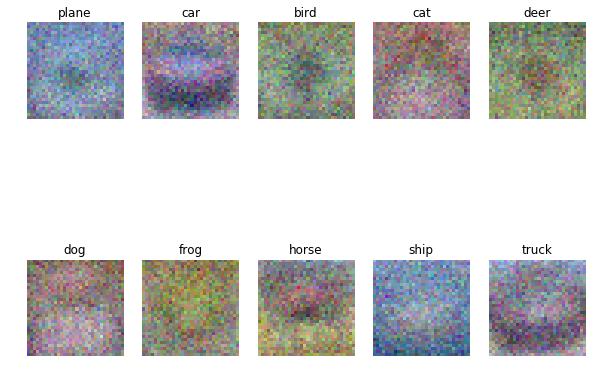

In [15]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])